# Data Wrangling for _WeRateDogs_
>By Sheima Ashour

---

### Table of Content

- Project Overview
- Project Wrangling
    a)Gathering Data
        1- File in Hand(Twitter Archive File)
        2- File Downloaded Programmatically(Image Predictions)
        3- File Download from Internet(Twitter API & JSON)
  
    b)Assessing Data
    
    c)Cleaning Data
    
- Storing, Analyzing and Visualizing


### Project Overview

First of all, loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests 
import json 
import tweepy
import re
import os
import datetime as dt

This bit of code is just to enhance tables display

In [2]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
    }
</style>

### Project Wrangling

#### a) Gathering

1- File in Hand: Twitter Archive File
Downloading the file *manually* 

In [3]:
#Read CSV file 
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

2- File Download Programmatically :Tweet Image Predictions
[The file is hosted on Udacity's servers](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)

In [4]:
#Use Requests library to programmatically download tsv file from a website 

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
folder_name = 'image-predictions.tsv'
response = requests.get(url)

# Save tsv to file
with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

In [5]:
#Read TSV file in pandas dataframe
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

3- Twitter API & JSON

In [13]:
# Authentication Details:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

# Getting tweet JSON data via tweet ID using Tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [15]:
# Checking if the Twitter API is working or not
exp_tweet = api.get_status(twitter_archive.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
content

{'created_at': 'Wed Jun 29 01:23:16 +0000 2016',
 'id': 747963614829678593,
 'id_str': '747963614829678593',
 'full_text': 'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q',
 'truncated': False,
 'display_text_range': [0, 70],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 747963600220917761,
    'id_str': '747963600220917761',
    'indices': [71, 94],
    'media_url': 'http://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'url': 'https://t.co/ZPfeRtOX0Q',
    'display_url': 'pic.twitter.com/ZPfeRtOX0Q',
    'expanded_url': 'https://twitter.com/dog_rates/status/747963614829678593/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 937, 'h': 632, 'resize': 'fit'},
     'small': {'w': 680, 'h': 459, 'resize': 'fit'},
     'large': {'w': 937, 'h': 632, '

In [6]:
# Query all of the tweet IDs in Twitter archive and print each tweet out after it was queried 
errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in twitter_archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

In [7]:
# Writing tweet ID data to the required tweet_json.txt file
# Append each tweet into a list
tweet_list = []
# Read this file, line by line, to create a pandas DataFrame df_api
with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_list.append(tweet)

In [8]:
# Create dataframe for tweet data
df_api = pd.DataFrame(tweet_list)

In [9]:
# Slicing Dataframe to the required columns
df_api=df_api[['id','favorite_count','retweet_count']]

In [10]:
# For future 
df_api.to_csv('df_api.csv', index=False)

Now, we have three Dataframes:
1- twitter_archive
2- image_prediction
3- df_api

#### b) Assessing

Assessing each dataframe for Quality & Tidiness both Visualy and Programmatically.

#### $Visual Assessment$


In [13]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [114]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
df_api

,id,favorite_count,retweet_count
0,892420643555336193,35003,7349
1,892177421306343426,30314,5480
2,891815181378084864,22801,3624
3,891689557279858688,38272,7535
4,891327558926688256,36547,8119
5,891087950875897856,18434,2715
6,890971913173991426,10724,1758
7,890729181411237888,58955,16476
8,890609185150312448,25363,3769
9,890240255349198849,28948,6381


#### $Programmatic Assessment$

Twitter Archive

In [15]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [17]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
twitter_archive.tweet_id.duplicated().sum()

0

In [17]:
twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Oliver         11
Lucy           11
Tucker         10
Penny          10
Lola           10
Winston         9
Bo              9
the             8
Sadie           8
Bailey          7
Buddy           7
an              7
Daisy           7
Toby            7
Bella           6
Leo             6
Jax             6
Stanley         6
Milo            6
Oscar           6
Rusty           6
Dave            6
Jack            6
Scout           6
Koda            6
Chester         5
             ... 
Edd             1
Socks           1
Crumpet         1
William         1
Brownie         1
Brian           1
Rorie           1
Jim             1
Brutus          1
Grizzwald       1
Steve           1
Zeek            1
Jareld          1
Chuck           1
Florence        1
Todo            1
Rizzo           1
Rupert          1
Baron           1
Mitch           1
Link            1
Pippin          1
Rose            1
Bobb            1
Jackie    

In [18]:
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [19]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
# Ratings above 10
twitter_archive[twitter_archive.rating_numerator > 10].shape

(1455, 17)

In [32]:
twitter_archive[twitter_archive.rating_numerator < 10].shape

(440, 17)

In [20]:
#Denominators less than 10 counts
twitter_archive[twitter_archive.rating_denominator < 10].shape

(3, 17)

In [21]:
#Denominators greater than 10 counts
twitter_archive[twitter_archive.rating_denominator > 10].shape

(20, 17)

In [31]:
twitter_archive[twitter_archive['rating_denominator']>10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


Image Predictions

In [37]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
image_prediction.tweet_id.duplicated().sum()

0

In [38]:
image_prediction.jpg_url.duplicated().sum()

66

In [39]:
image_prediction.groupby('jpg_url')['jpg_url'].nunique().sum()

2009

In [35]:
image_prediction[image_prediction.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [39]:
image_prediction.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [40]:
image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [37]:
image_prediction['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [38]:
image_prediction['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [41]:
image_prediction[(image_prediction['p1_dog']==False) & (image_prediction['p2_dog']==False) & (image_prediction['p3_dog']==False)].count()

tweet_id    324
jpg_url     324
img_num     324
p1          324
p1_conf     324
p1_dog      324
p2          324
p2_conf     324
p2_dog      324
p3          324
p3_conf     324
p3_dog      324
dtype: int64

In [42]:
image_prediction['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
Maltese_dog                   18
Eskimo_dog                    18
teddy                         18
beagle                        18
Shetland_sheepdog             18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
Italian_greyhound             16
kuvasz                        16
          

In [39]:
image_prediction[image_prediction.img_num > 1].shape

(295, 12)

Additional Information from Tweet API

In [40]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [41]:
df_api.head()

,id,favorite_count,retweet_count
0,892420643555336193,35003,7349
1,892177421306343426,30314,5480
2,891815181378084864,22801,3624
3,891689557279858688,38272,7535
4,891327558926688256,36547,8119


In [45]:
df_api.id.duplicated().sum()

0

In [47]:
df_api.groupby('id')['id'].nunique().sum()

2331

In [51]:
df_api.favorite_count.describe()

count      2331.000000
mean       7309.143286
std       11352.384397
min           0.000000
25%        1267.000000
50%        3171.000000
75%        8936.500000
max      150455.000000
Name: favorite_count, dtype: float64

In [65]:
df_api.id[df_api.favorite_count == 150455]

1015    744234799360020481
Name: id, dtype: int64

In [52]:
df_api.retweet_count.describe()

count     2331.000000
mean      2586.816817
std       4375.747828
min          1.000000
25%        524.500000
50%       1206.000000
75%       2994.500000
max      74240.000000
Name: retweet_count, dtype: float64

### Observations:

#### Quality Issues:

###### twitter_archive:
      *Visual assessment:*
      - Null represented as $text$ 'None' in columns(doggo, floofer, pupper,	puppo).
      - Incorrect values in "name" column ('a', 'quite', 'not'), names are not capitalized.
      - Missing data in "name" column.
      *Programmatic Assessment:*
      -  181 rows are retweets, 78 replies.
      - Erroneous datatype for (tweet_id, timestamp).
      - rating_numerator: two values has "0", 1455 has greater then 10, 440 less than 10.
      - rating_denominator: one value only has "0", 20 has greater then 10, 3 less than 10 and 2333 equal to 10.
      - 'source' url is not useful.

###### image_prediction:
      *Visual assessment:*
      - Values in P1,P2 & P3 are not standerdized(some lower case others are upper case).
      - 324 images are not dogs  ('bath_tub', 'box_turtle', 'goose').
      - Some IDs have more than 1 image and only one considered.
      *Programmatic Assessment:*
      - Erroneous datatype for tweet_id.
      - Duplicated jpg_url

##### df_api:
      *Visual assessment:*
      - "id" column should be "tweet_id".
      *Programmatic Assessment:*
      - Erroneous datatype for id.


#### Tidiness Issues:

###### twitter_archive:
- dog stages (doggo, puppo, pupper, floofer) can be combined into one column 'dog_stage'.

###### image_prediction:
- Prediction column for (p1_dog,p2_dog,p3_dog) can be useful.

##### General:
- Merging all dataframes into one or two Master datasets.

### c) Cleaning

Before starting and cleaning, Create copies of the dataframes to use for cleaning and keep the originals for reference.

In [11]:
#First of all, create copies of the dataframes
archive_clean = twitter_archive.copy()
image_clean = image_prediction.copy()
tweet_clean = df_api.copy()

Firstly, address missing data, then address tidiness issues and finally quality issues.

##### Missing Data

##### Define

- We can ignore the missing data in "name" column as we will not deal with it in analysis and deal with ID.

- Remove 181 retweets by removing rows first then drop the columns 'retweeted_status_id', 'retweeted_status_user_id' and 'retweeted_status_timestamp' as we are interested in original tweets only by drop(), same for reply.

##### Code

In [12]:
# Remove rows
archive_clean.drop(archive_clean[archive_clean.retweeted_status_id.notnull()].index, inplace=True)
archive_clean.drop(archive_clean[archive_clean.in_reply_to_status_id.notnull()].index, inplace=True)

In [13]:
# Remove columns
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'], axis=1, inplace=True)

##### Test

In [15]:
archive_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [16]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


##### Define

Convert datatype for "timestamp" column to datetime.

##### Code

In [14]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

##### Test

In [15]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


##### Define

Replace source links with text string defining the link.

##### Code

In [16]:
# Text replacements
source_txt = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
 '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Vine - Make a Scene',
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'}

# Apply function
def text_source(archive_clean):
    if archive_clean['source'] in source_txt.keys():
        abbrev = source_txt[archive_clean['source']]
        return abbrev
    else:
        return archive_clean['source']

archive_clean['source'] = archive_clean.apply(text_source, axis=1)

##### Test

In [17]:
archive_clean.source.sample()

29    Twitter for iPhone
Name: source, dtype: object

#### Tidiness

##### Define

Collect dog stages columns to one column, converting first the 'None' values to " " to be able to add them, then combine (doggo, floofer, pupper, puppo) to 'dog_stage', fill the NaN values with "unknown" to be expressive, drop the unnecessary columns and convert its datatype to category.

##### Code

In [18]:
#Replace None with ' '
archive_clean.doggo = archive_clean.doggo.replace('None', '')
archive_clean.floofer = archive_clean.floofer.replace('None', '')
archive_clean.pupper = archive_clean.pupper.replace('None', '')
archive_clean.puppo = archive_clean.puppo.replace('None', '')

In [19]:
# Create a new column for dog_stage
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo
archive_clean.dog_stage.value_counts()

                1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [20]:
# Replace blank cells with 'NaNs' 
archive_clean.loc[archive_clean.dog_stage == '', 'dog_stage'] = np.nan
# Replace NaNs with 'unknown'
archive_clean.dog_stage = archive_clean.dog_stage.fillna('Unknown')

In [21]:
# Drop 'doggo', 'floofer', 'pupper', 'puppo' columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace= True)

In [22]:
#Change dog_stage datatype to category
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

In [24]:
#Rename the categories with titled ones
archive_clean.dog_stage[archive_clean.dog_stage == 'pupper']
archive_clean["dog_stage"].replace({"pupper": "Pupper", "doggo": "Doggo", "puppo": "Puppo", "doggopupper":"Doggo, Pupper", "floofer":"Floofer", "doggopuppo": "Doggo, Puppo","doggofloofer":"Doggo, Floofer"}, inplace=True)

##### Test

In [23]:
archive_clean.dog_stage.sample(5)

883     Unknown
1157     pupper
1510    Unknown
553     Unknown
1221    Unknown
Name: dog_stage, dtype: category
Categories (8, object): [Unknown, doggo, doggofloofer, doggopupper, doggopuppo, floofer, pupper, puppo]

In [24]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
dog_stage             2097 non-null category
dtypes: category(1), datetime64[ns](1), int64(3), object(4)
memory usage: 149.9+ KB


##### Define

Rename 'id' column in df_api to 'tweet_id' to be easily merged with other dataframes.

##### Code

In [25]:
# Change the"id" column to "tweet_id"
tweet_clean.rename(columns = {'id':'tweet_id'}, inplace = True)

##### Test

In [26]:
tweet_clean.head(2)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,35003,7349
1,892177421306343426,30314,5480


##### Define

Join tweet_clean and archive_clean on tweet_id

##### Code

In [27]:
#Check for duplicates
all_columns = pd.Series(list(archive_clean) + list(tweet_clean))

In [28]:
all_columns[all_columns.duplicated()]

9    tweet_id
dtype: object

In [29]:
twitter_archive_master = pd.merge(archive_clean, tweet_clean, on='tweet_id', how = 'inner')

##### Test

In [30]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 11 columns):
tweet_id              2090 non-null int64
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  2090 non-null object
dog_stage             2090 non-null category
favorite_count        2090 non-null int64
retweet_count         2090 non-null int64
dtypes: category(1), datetime64[ns](1), int64(5), object(4)
memory usage: 182.0+ KB


In [112]:
twitter_archive_master.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,Unknown,35003,7349
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,30314,5480
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,22801,3624


In [31]:
twitter_archive_master.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         3
rating_numerator      0
rating_denominator    0
name                  0
dog_stage             0
favorite_count        0
retweet_count         0
dtype: int64

##### Define

Extracting year, month, day and time from "timestamp" column for analysis and visualization

##### Code

In [32]:
# Extract datetime to new year, month, day, time columns
twitter_archive_master['year'] = twitter_archive_master['timestamp'].dt.year 
twitter_archive_master['month'] = twitter_archive_master['timestamp'].dt.month
twitter_archive_master['day'] = twitter_archive_master['timestamp'].dt.day
twitter_archive_master['time'] = twitter_archive_master['timestamp'].dt.time

In [33]:
twitter_archive_master['day_of_week'] = twitter_archive_master['timestamp'].dt.day_name()

##### Test

In [37]:
twitter_archive_master.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,year,month,day,time,day_of_week
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,35003,7349,2017,8,1,16:23:56,Tuesday
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,30314,5480,2017,8,1,00:17:27,Tuesday


In [34]:
twitter_archive_master['day_of_week'].value_counts()

Monday       352
Tuesday      312
Wednesday    308
Thursday     292
Friday       290
Saturday     268
Sunday       268
Name: day_of_week, dtype: int64

##### Define

Create a new column for the dog prediction summary in image_prediction to give 3 values, then change its datatype to category.

##### Code

In [35]:
image_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [36]:
# Convert p1_dog, p2_dog, p3_dog to an integer (True=1, False=0)
p_dog = ['p1_dog','p2_dog','p3_dog']
for p in p_dog:
    image_clean[p] = image_clean[p].astype(int)

In [37]:
# Create a new column by adding the total number of True and False
image_clean['prediction'] = image_clean.p1_dog + image_clean.p2_dog + image_clean.p3_dog

In [38]:
# Replace the number with a defining text string
image_clean['prediction'].replace({3: "Dog", 2: "May be a Dog", 1: "May be a Dog", 0:"Not a Dog"}, inplace=True)

In [39]:
#Change dog_stage datatype to category
image_clean.prediction = image_clean.prediction.astype('category')

##### Test

In [40]:
image_clean.prediction.value_counts()

Dog             1243
May be a Dog     508
Not a Dog        324
Name: prediction, dtype: int64

In [41]:
image_clean.prediction.describe()

count     2075
unique       3
top        Dog
freq      1243
Name: prediction, dtype: object

In [42]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 13 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
img_num       2075 non-null int64
p1            2075 non-null object
p1_conf       2075 non-null float64
p1_dog        2075 non-null int64
p2            2075 non-null object
p2_conf       2075 non-null float64
p2_dog        2075 non-null int64
p3            2075 non-null object
p3_conf       2075 non-null float64
p3_dog        2075 non-null int64
prediction    2075 non-null category
dtypes: category(1), float64(3), int64(5), object(4)
memory usage: 196.7+ KB


##### Define

Drop unnecessary columns:
(p1_dog, p2_dog, p3_dog) preparing for joining it to twitter_archive_master
(img_num) as it is not useful.

##### Code

In [43]:
image_clean.drop(['p1_dog', 'p2_dog', 'p3_dog', 'img_num'], axis=1, inplace=True)

##### Test

In [44]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 9 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
p1            2075 non-null object
p1_conf       2075 non-null float64
p2            2075 non-null object
p2_conf       2075 non-null float64
p3            2075 non-null object
p3_conf       2075 non-null float64
prediction    2075 non-null category
dtypes: category(1), float64(3), int64(1), object(4)
memory usage: 131.9+ KB


##### Define

Combining twitter_archive_master & image_clean (First Master Dataframe)

##### Code

In [45]:
all_columns = pd.Series(list(twitter_archive_master) + list(image_clean))

In [46]:
all_columns[all_columns.duplicated()]

16    tweet_id
dtype: object

In [47]:
twitter_archive_master = pd.merge(twitter_archive_master, image_clean, on='tweet_id')

##### Test

In [48]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 24 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
dog_stage             1964 non-null category
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
year                  1964 non-null int64
month                 1964 non-null int64
day                   1964 non-null int64
time                  1964 non-null object
day_of_week           1964 non-null object
jpg_url               1964 non-null object
p1                    1964 non-null object
p1_conf               1964 non-null float64
p2                    1964 non-null object
p2_conf               1964 non

In [49]:
twitter_archive_master.sample(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,...,time,day_of_week,jpg_url,p1,p1_conf,p2,p2_conf,p3,p3_conf,prediction
854,728015554473250816,2016-05-05 00:16:48,Twitter for iPhone,This is Rueben. He has reached ultimate pupper...,https://twitter.com/dog_rates/status/728015554...,11,10,Rueben,pupper,3959,...,00:16:48,Thursday,https://pbs.twimg.com/media/ChpuRyvVAAARMoq.jpg,cocker_spaniel,0.384559,golden_retriever,0.091661,sandbar,0.081799,May be a Dog
1778,669371483794317312,2015-11-25 04:26:12,Twitter for iPhone,This is Oliviér. He's a Baptist Hindquarter. A...,https://twitter.com/dog_rates/status/669371483...,10,10,Oliviér,Unknown,455,...,04:26:12,Wednesday,https://pbs.twimg.com/media/CUoVz8rU8AAfW-c.jpg,Brabancon_griffon,0.483268,miniature_pinscher,0.307465,redbone,0.070524,Dog


##### Define

Drop 'rating_denominator' column as the majority of values are 10 and renaming 'rating_numerator' to rating (out of 10).

##### Code

In [50]:
twitter_archive_master.drop(['rating_denominator'], axis=1, inplace=True)
twitter_archive_master.rename(columns={'rating_numerator': 'rating (out of 10)'}, inplace=True)

##### Test

In [51]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 23 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating (out of 10)    1964 non-null int64
name                  1964 non-null object
dog_stage             1964 non-null category
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
year                  1964 non-null int64
month                 1964 non-null int64
day                   1964 non-null int64
time                  1964 non-null object
day_of_week           1964 non-null object
jpg_url               1964 non-null object
p1                    1964 non-null object
p1_conf               1964 non-null float64
p2                    1964 non-null object
p2_conf               1964 non-null float64
p3                    1964 n

##### Define

Convert confidence levels to a percentage by multiplying by 100, converting the float to an integer, and
displaying only 2 numbers.

##### Code

In [52]:
confidence =  ['p1_conf', 'p2_conf', 'p3_conf']

for c in confidence:
    twitter_archive_master[c] = round(twitter_archive_master[c]*100).astype(int)

##### Test

In [53]:
twitter_archive_master[['p1_conf', 'p2_conf', 'p3_conf']].sample(5)

,p1_conf,p2_conf,p3_conf
7,57,18,8
916,74,8,6
380,75,17,7
1591,87,9,3
1629,33,26,12


##### Define

Rename p1, p2, p3 & p1_conf, p2_conf, p3_conf with more expressive names.

##### Code

In [54]:
twitter_archive_master.rename(columns={'p1': 'predict_1', 'p2': 'predict_2', 'p3': 'predict_3'}, inplace=True)
twitter_archive_master.rename(columns={'p1_conf': 'confidence%_1', 'p2_conf': 'confidence%_2', 'p3_conf': 'confidence%_3'}, inplace=True)

##### Test

In [55]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 23 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating (out of 10)    1964 non-null int64
name                  1964 non-null object
dog_stage             1964 non-null category
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
year                  1964 non-null int64
month                 1964 non-null int64
day                   1964 non-null int64
time                  1964 non-null object
day_of_week           1964 non-null object
jpg_url               1964 non-null object
predict_1             1964 non-null object
confidence%_1         1964 non-null int64
predict_2             1964 non-null object
confidence%_2         1964 non-null int64
predict_3             1964 non-n

In [143]:
twitter_archive_master.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating (out of 10)    0
name                  0
dog_stage             0
favorite_count        0
retweet_count         0
year                  0
month                 0
day                   0
time                  0
day_of_week           0
jpg_url               0
predict_1             0
confidence%_1         0
predict_2             0
confidence%_2         0
predict_3             0
confidence%_3         0
prediction            0
dtype: int64

In [56]:
twitter_archive_master.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating (out of 10),name,dog_stage,favorite_count,retweet_count,...,time,day_of_week,jpg_url,predict_1,confidence%_1,predict_2,confidence%_2,predict_3,confidence%_3,prediction
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,Unknown,35003,7349,...,16:23:56,Tuesday,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,10,bagel,9,banana,8,Not a Dog
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,Unknown,30314,5480,...,00:17:27,Tuesday,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,32,Pekinese,9,papillon,7,Dog


##### Define

Titling values in the columns predict_1, predict_2, predict_3

##### Code

In [63]:
twitter_archive_master['predict_1'] = twitter_archive_master['predict_1'].str.title()
twitter_archive_master['predict_2'] = twitter_archive_master['predict_2'].str.title()
twitter_archive_master['predict_3'] = twitter_archive_master['predict_3'].str.title()

##### Test

In [90]:
twitter_archive_master.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating (out of 10),name,dog_stage,favorite_count,retweet_count,...,time,day_of_week,jpg_url,predict_1,confidence%_1,predict_2,confidence%_2,predict_3,confidence%_3,prediction
811,737310737551491075,2016-05-30 15:52:33,Twitter for iPhone,Everybody stop what you're doing and watch the...,https://twitter.com/dog_rates/status/737310737...,13,None,Unknown,14066,7067,...,15:52:33,Monday,https://pbs.twimg.com/ext_tw_video_thumb/73731...,Cliff,44,Lakeside,6,Valley,4,Not a Dog
1660,671528761649688577,2015-12-01 03:18:27,Twitter for iPhone,Meet Jax. He's in the middle of a serious conv...,https://twitter.com/dog_rates/status/671528761...,10,Jax,Unknown,781,235,...,03:18:27,Tuesday,https://pbs.twimg.com/media/CVG_2I-WIAASKSS.jpg,Doberman,78,Black-And-Tan_Coonhound,11,Gordon_Setter,5,Dog
1833,668466899341221888,2015-11-22 16:31:42,Twitter for iPhone,Here is a mother dog caring for her pups. Snaz...,https://twitter.com/dog_rates/status/668466899...,4,a,Unknown,814,465,...,16:31:42,Sunday,https://pbs.twimg.com/media/CUbfGbbWoAApZth.jpg,Shopping_Basket,40,Hamper,36,Bassinet,8,Not a Dog
996,707693576495472641,2016-03-09 22:24:31,Twitter for iPhone,This is Jiminus. He's in a tub for some reason...,https://twitter.com/dog_rates/status/707693576...,7,Jiminus,Unknown,3261,953,...,22:24:31,Wednesday,https://pbs.twimg.com/media/CdI7jDnW0AA2dtO.jpg,Bathtub,50,Tub,49,Washbasin,1,Not a Dog
1455,676470639084101634,2015-12-14 18:35:43,Twitter for iPhone,Three generations of pupper. 11/10 for all htt...,https://twitter.com/dog_rates/status/676470639...,11,None,pupper,11001,4387,...,18:35:43,Monday,https://pbs.twimg.com/media/CWNOdIpWoAAWid2.jpg,Golden_Retriever,79,Borzoi,2,Dingo,2,May be a Dog


##### Define

Convert 'tweet_id' from integer to string

##### Code

In [91]:
twitter_archive_master['tweet_id'] = twitter_archive_master['tweet_id'].astype(str)

##### Test

In [92]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 23 columns):
tweet_id              1964 non-null object
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating (out of 10)    1964 non-null int64
name                  1964 non-null object
dog_stage             1964 non-null category
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
year                  1964 non-null int64
month                 1964 non-null int64
day                   1964 non-null int64
time                  1964 non-null object
day_of_week           1964 non-null object
jpg_url               1964 non-null object
predict_1             1964 non-null object
confidence%_1         1964 non-null int64
predict_2             1964 non-null object
confidence%_2         1964 non-null int64
predict_3             1964 non-

So, this is our Master Dataframe "twitter_archive_master".

##### Define

Extract from the master dataframe a copy for the dogs and reorder columns for clearer analysis.

##### Code

In [93]:
# Copy for the data that we are certain that they are for Dogs
twitter_dog_master = twitter_archive_master[twitter_archive_master['prediction'] == 'Dog'].copy()

In [94]:
# Drop unnecessary columns
twitter_dog_master.drop(['predict_2','confidence%_2', 'predict_3', 'confidence%_3', 'prediction', 'expanded_urls'], axis=1, inplace=True)

In [95]:
# Renaming columns with expressive names
twitter_dog_master.rename(columns={'predict_1': 'Breed', 'confidence%_1': 'confidence%'}, inplace=True)

In [96]:
twitter_dog_master.head(3)

,tweet_id,timestamp,source,text,rating (out of 10),name,dog_stage,favorite_count,retweet_count,year,month,day,time,day_of_week,jpg_url,Breed,confidence%
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,Tilly,Unknown,30314,5480,2017,8,1,00:17:27,Tuesday,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,32
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,Archie,Unknown,22801,3624,2017,7,31,00:18:03,Monday,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,72
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,Franklin,Unknown,36547,8119,2017,7,29,16:00:24,Saturday,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset,56


In [97]:
# Reindex 
twitter_dog_master = twitter_dog_master.reindex(['tweet_id','name', 'Breed', 'rating (out of 10)','dog_stage', 'favorite_count', 'retweet_count','text', 'timestamp', 'jpg_url'], axis=1)

#### Test

In [98]:
twitter_dog_master.head(2) 

,tweet_id,name,Breed,rating (out of 10),dog_stage,favorite_count,retweet_count,text,timestamp,jpg_url
1,892177421306343426,Tilly,Chihuahua,13,Unknown,30314,5480,This is Tilly. She's just checking pup on you....,2017-08-01 00:17:27,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,Archie,Chihuahua,12,Unknown,22801,3624,This is Archie. He is a rare Norwegian Pouncin...,2017-07-31 00:18:03,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg


## Storing

In [99]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)
twitter_dog_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing, and Visualizing Data

1- Most popular breed

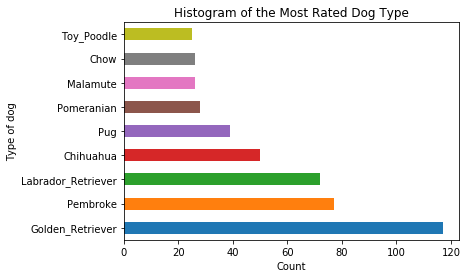

In [100]:
#Top rated:
twitter_dog_master = twitter_dog_master.groupby('Breed').filter(lambda x: len(x) >= 25)
twitter_dog_master['Breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

So, as we can see the "Golden Retriever" is the most rated dog.

2- Top Dog Stage

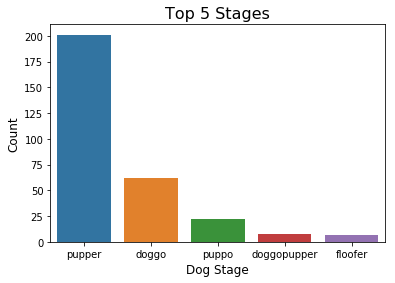

In [101]:
sorted_stage=twitter_archive_master['dog_stage'].value_counts()[1:6].index
sns.countplot(data = twitter_archive_master, x = 'dog_stage', order = sorted_stage, orient = 'h')
plt.xlabel('Dog Stage', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 5 Stages',fontsize=16)
plt.savefig('top-stages.png');

3- Most Day and Month has engagement

In [102]:
twitter_archive_master['day_of_week'].value_counts()

Monday       326
Wednesday    291
Tuesday      291
Friday       277
Thursday     277
Sunday       254
Saturday     248
Name: day_of_week, dtype: int64

Most engagment day is Monday.

In [103]:
twitter_archive_master['month'].value_counts()

12    413
11    347
1     232
2     171
3     163
7     136
6     122
5      98
4      94
10     65
9      62
8      61
Name: month, dtype: int64

Most engagement month is December.

top rated dogs

In [104]:
twitter_archive_master.sort_values(by=['rating (out of 10)'], ascending=False).head()

,tweet_id,timestamp,source,text,expanded_urls,rating (out of 10),name,dog_stage,favorite_count,retweet_count,...,time,day_of_week,jpg_url,predict_1,confidence%_1,predict_2,confidence%_2,predict_3,confidence%_3,prediction
716,749981277374128128,2016-07-04 15:00:45,TweetDeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,Atticus,Unknown,4942,2374,...,15:00:45,Monday,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,Bow_Tie,53,Sunglasses,8,Sunglass,5,Not a Dog
1689,670842764863651840,2015-11-29 05:52:33,Twitter for iPhone,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420,None,Unknown,22925,7944,...,05:52:33,Sunday,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,Microphone,10,Accordion,9,Drumstick,6,Not a Dog
836,731156023742988288,2016-05-13 16:15:54,Twitter for iPhone,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,this,Unknown,3684,1207,...,16:15:54,Friday,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,Lakeside,50,Breakwater,5,King_Penguin,5,Not a Dog
653,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,None,Unknown,4660,2135,...,01:00:57,Thursday,https://pbs.twimg.com/ext_tw_video_thumb/75846...,Labrador_Retriever,44,Chihuahua,11,American_Staffordshire_Terrier,10,Dog
1413,677716515794329600,2015-12-18 05:06:23,Twitter for iPhone,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,https://twitter.com/dog_rates/status/677716515...,144,None,Unknown,2894,922,...,05:06:23,Friday,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,Teddy,66,Crib,3,Chow,3,May be a Dog


Top favorited dogs

In [85]:
twitter_archive_master.sort_values(by=['favorite_count'], ascending=False).head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating (out of 10),name,dog_stage,favorite_count,retweet_count,...,time,day_of_week,jpg_url,predict_1,confidence%_1,predict_2,confidence%_2,predict_3,confidence%_3,prediction
763,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,None,Doggo,150455,74240,...,18:26:18,Saturday,https://pbs.twimg.com/ext_tw_video_thumb/74423...,Labrador_retriever,83,ice_bear,4,whippet,2,May be a Dog
302,822872901745569793,2017-01-21 18:26:02,Twitter for iPhone,Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,None,Puppo,128673,41854,...,18:26:02,Saturday,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland_terrier,20,Labrador_retriever,16,Irish_terrier,7,Dog


In [116]:
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '744234799360020481', 'text']

763    Here's a doggo realizing you can stand in a po...
Name: text, dtype: object

Top retweeted dogs

In [80]:
twitter_archive_master.sort_values(by=['retweet_count'], ascending=False).head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating (out of 10),name,dog_stage,favorite_count,retweet_count,...,time,day_of_week,jpg_url,predict_1,confidence%_1,predict_2,confidence%_2,predict_3,confidence%_3,prediction
763,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,None,doggo,150455,74240,...,18:26:18,Saturday,https://pbs.twimg.com/ext_tw_video_thumb/74423...,Labrador_Retriever,83,Ice_Bear,4,Whippet,2,May be a Dog
798,739238157791694849,2016-06-04 23:31:25,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13,None,doggo,111286,55323,...,23:31:25,Saturday,https://pbs.twimg.com/ext_tw_video_thumb/73923...,Eskimo_Dog,50,Siberian_Husky,39,Malamute,8,Dog


4- Favorites and Retweets Analysis

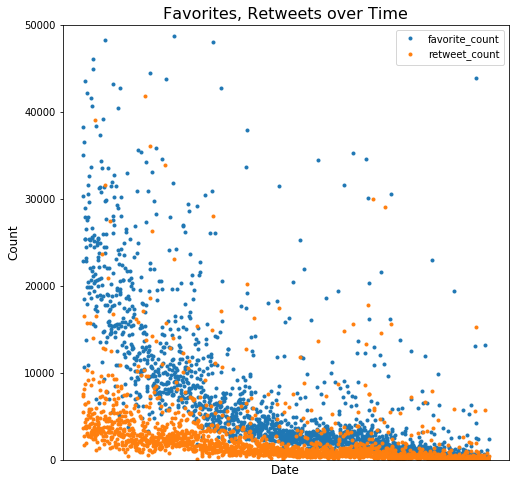

In [81]:
twitter_archive_master[['favorite_count', 'retweet_count']].plot(style ='.', ylim=[0, 50000], figsize=(8,8))
plt.title('Favorites, Retweets over Time', size=16)
plt.xlabel('Date', size=12)
plt.xticks([], [])
plt.ylabel('Count', size=12)
plt.legend(ncol=1, loc='upper right')
plt.savefig('retweets-favorites-time.png');

As we can see Favorites are more popular than retweets. Both are decreasing by time.

4- Retweets and favorities counts comparing to new tweets creation

In [82]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 23 columns):
tweet_id              1964 non-null object
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating (out of 10)    1964 non-null int64
name                  1964 non-null object
dog_stage             1964 non-null category
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
year                  1964 non-null int64
month                 1964 non-null int64
day                   1964 non-null int64
time                  1964 non-null object
day_of_week           1964 non-null object
jpg_url               1964 non-null object
predict_1             1964 non-null object
confidence%_1         1964 non-null int64
predict_2             1964 non-null object
confidence%_2         1964 non-null int64
predict_3             1964 non-

In [83]:
tweets_time = twitter_archive_master.copy()

In [84]:
tweets_time['tweet_id'] = tweets_time['tweet_id'].astype(int)

In [85]:
tweets_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 23 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating (out of 10)    1964 non-null int64
name                  1964 non-null object
dog_stage             1964 non-null category
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
year                  1964 non-null int64
month                 1964 non-null int64
day                   1964 non-null int64
time                  1964 non-null object
day_of_week           1964 non-null object
jpg_url               1964 non-null object
predict_1             1964 non-null object
confidence%_1         1964 non-null int64
predict_2             1964 non-null object
confidence%_2         1964 non-null int64
predict_3             1964 non-n

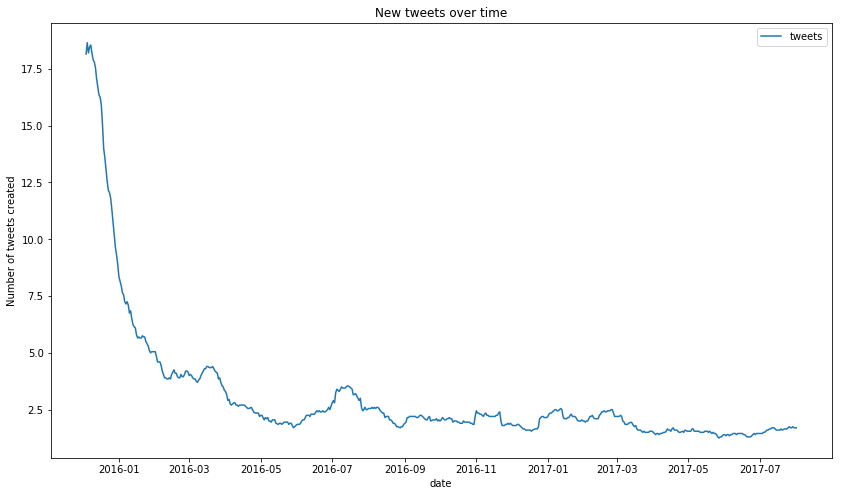

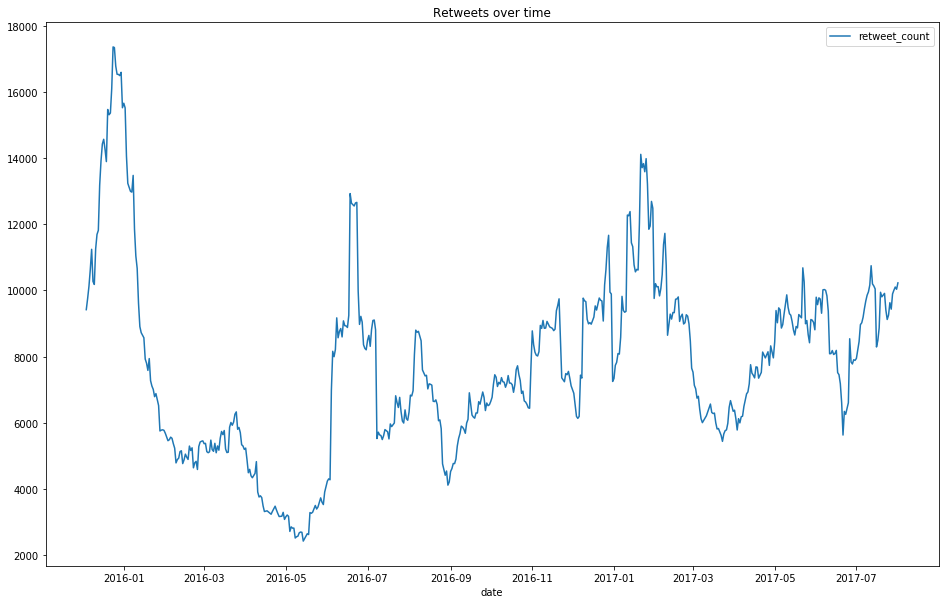

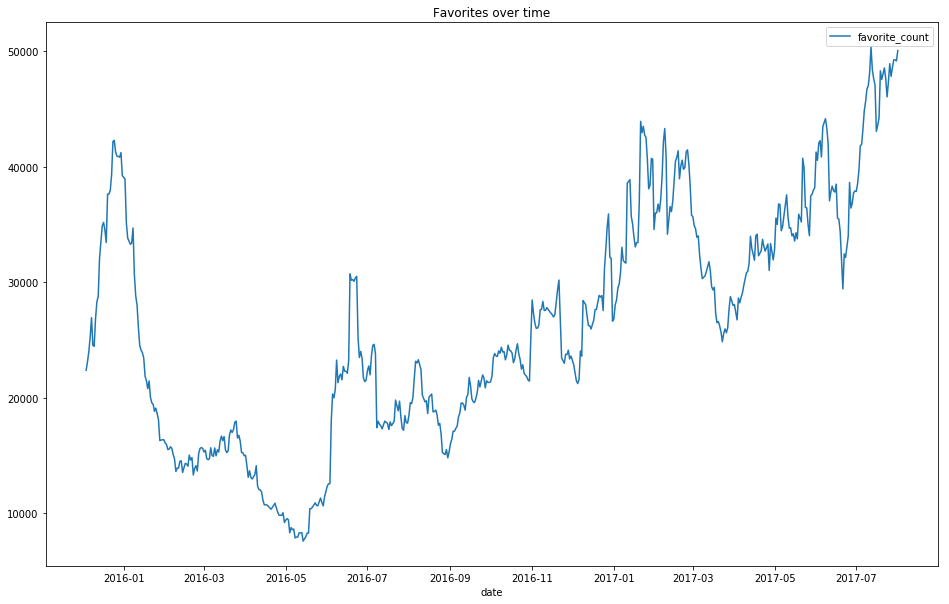

In [106]:
#Counting number of tweets over time
tweets_time['date'] = twitter_archive_master['timestamp'].dt.date
tweets_time['tweets'] = 1
df1 = tweets_time[['date', 'tweets']].groupby(['date']).sum()
df1['tweets'] = df1['tweets'].rolling(window=20).mean()

# Add rewteets and favorites to the picture
df = tweets_time[['date', 'retweet_count', 'favorite_count']]

# Plot
df1.plot(figsize=(14, 8), title='New tweets over time')
plt.ylabel('Number of tweets created')
plt.show();
plt.savefig("Tweets over time")

# Retweets
df2 = df[['date', 'retweet_count']].groupby(['date']).sum()
df2['retweet_count'] = df2['retweet_count'].rolling(window=20).mean()
df2.plot(figsize=(16, 10), title='Retweets over time')
plt.show();
plt.savefig("Retweets over time")

# Favorites
df3 = df[['date', 'favorite_count']].groupby(['date']).sum()
df3['favorite_count'] = df3['favorite_count'].rolling(window=20).mean()
df3.plot(figsize=(16, 10), title='Favorites over time')
plt.show();
plt.savefig("Favorites over time.png")

Tweets: A great start, then we can notice that the amount of tweets created daily stabilizes on around 2.5 per day on average.

Retweets:  there is noticable variation of retweets, but on average long-term they tend to stay at the same level.

Favorites: after initial boom and then colapse, the trend is growing. It seems people still use historical tweets and mark them as favotes or the user base is growing which results in more and more favorites.

The overall trend of the counts shows the popularity of this twitter page slowly growing overtime.